In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from scipy.special import expit
from scipy import interpolate
from scipy import integrate

In [56]:
import warnings
warnings.filterwarnings('default')

In [11]:
def interpolate_roc_fun(fpr, tpr, n_grid):
    """https://github.com/VaibhavKaushik3220/abroca/blob/main/abroca/compute_abroca.py"""
    roc_approx = interpolate.interp1d(x=fpr, y=tpr)
    x_new = np.linspace(0, 1, num=n_grid)
    y_new = roc_approx(x_new)
    return x_new, y_new

In [12]:
def compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1, n_grid=10000, lb=0, ub=1, limit=1000):
    """https://github.com/VaibhavKaushik3220/abroca/blob/main/abroca/compute_abroca.py"""
    # Compute the value of the abroca statistic.
    
    # compare minority to majority class; accumulate absolute difference btw ROC curves to slicing statistic
    majority_roc_x, majority_roc_y = interpolate_roc_fun(fpr_0, tpr_0, n_grid)
    minority_roc_x, minority_roc_y = interpolate_roc_fun(fpr_1, tpr_1, n_grid)

    # use function approximation to compute slice statistic via piecewise linear function
    assert list(majority_roc_x) == list(minority_roc_x), "Majority and minority FPR are different"
    f1 = interpolate.interp1d(x=majority_roc_x, y=(majority_roc_y - minority_roc_y))
    f2 = lambda x, acc: abs(f1(x))
    slice, _ = integrate.quad(f2, lb, ub, limit)

    return slice

### Simulate Data

In [69]:
def simulate(sigma_scale_factor=1, subgroup_n=[10000, 10000], mu_1=[0,0], mu_2=[0,0], sigma_1=[5,5], sigma_2=[5,5], rounding_thresh=[.5,.5], eta_sd=5):
    mu = [mu_1, mu_2]
    sigma = [np.diag(sigma_1),np.diag(np.dot(sigma_2, sigma_scale_factor))]

    X = np.array([])
    y = np.array([])

    for i in range(len(subgroup_n)):
        ax = np.random.multivariate_normal(mu[i],sigma[i],size=subgroup_n[i])
        X = np.append(X.reshape((-1,2)),ax,axis=0)

        aeta = np.random.normal(0,eta_sd) # change aeta mean to change group imbalance
        theta = np.ones((subgroup_n[i], 2))
        ap = expit(np.sum(theta*ax, axis=1) + aeta)
#         ay = np.random.binomial(len(ap), ap).reshape((-1))
#         ay = np.array(ap >= rounding_thresh[i], dtype=int)
        ay = (np.random.uniform(size=len(ap)) <= ap)
    #look at ay to see group imbalance
        y = np.append(y, ay, axis=0)
        
        
    return X, y
    

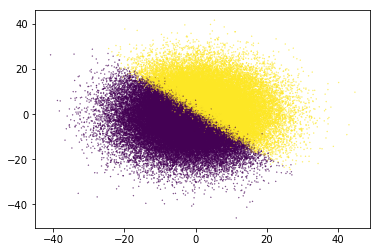

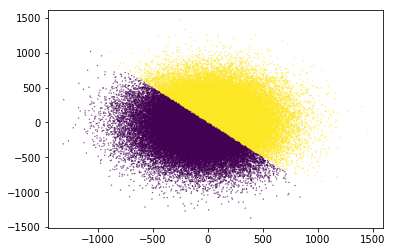

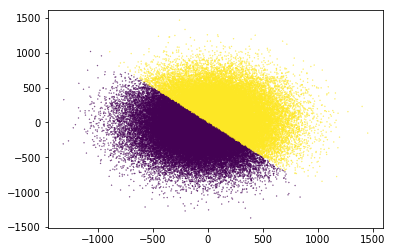

In [78]:
n = [100000, 100000]
X, y = simulate(sigma_scale_factor=a_s, subgroup_n=n, sigma_1=[100,100], sigma_2=[100,100], eta_sd=1)

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

X_train = np.append(X_train_0, X_train_1, axis=0)
y_train = np.append(y_train_0, y_train_1, axis=0)

plt.scatter(X_train_0[:,0], X_train_0[:,1], c=y_train_0, s=0.1)
plt.show()
plt.scatter(X_train_1[:,0], X_train_1[:,1], c=y_train_1, s=0.1)
plt.show()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=0.1)
plt.show()

### Regression and Main Plot

average auc score: 0.7468842449439528


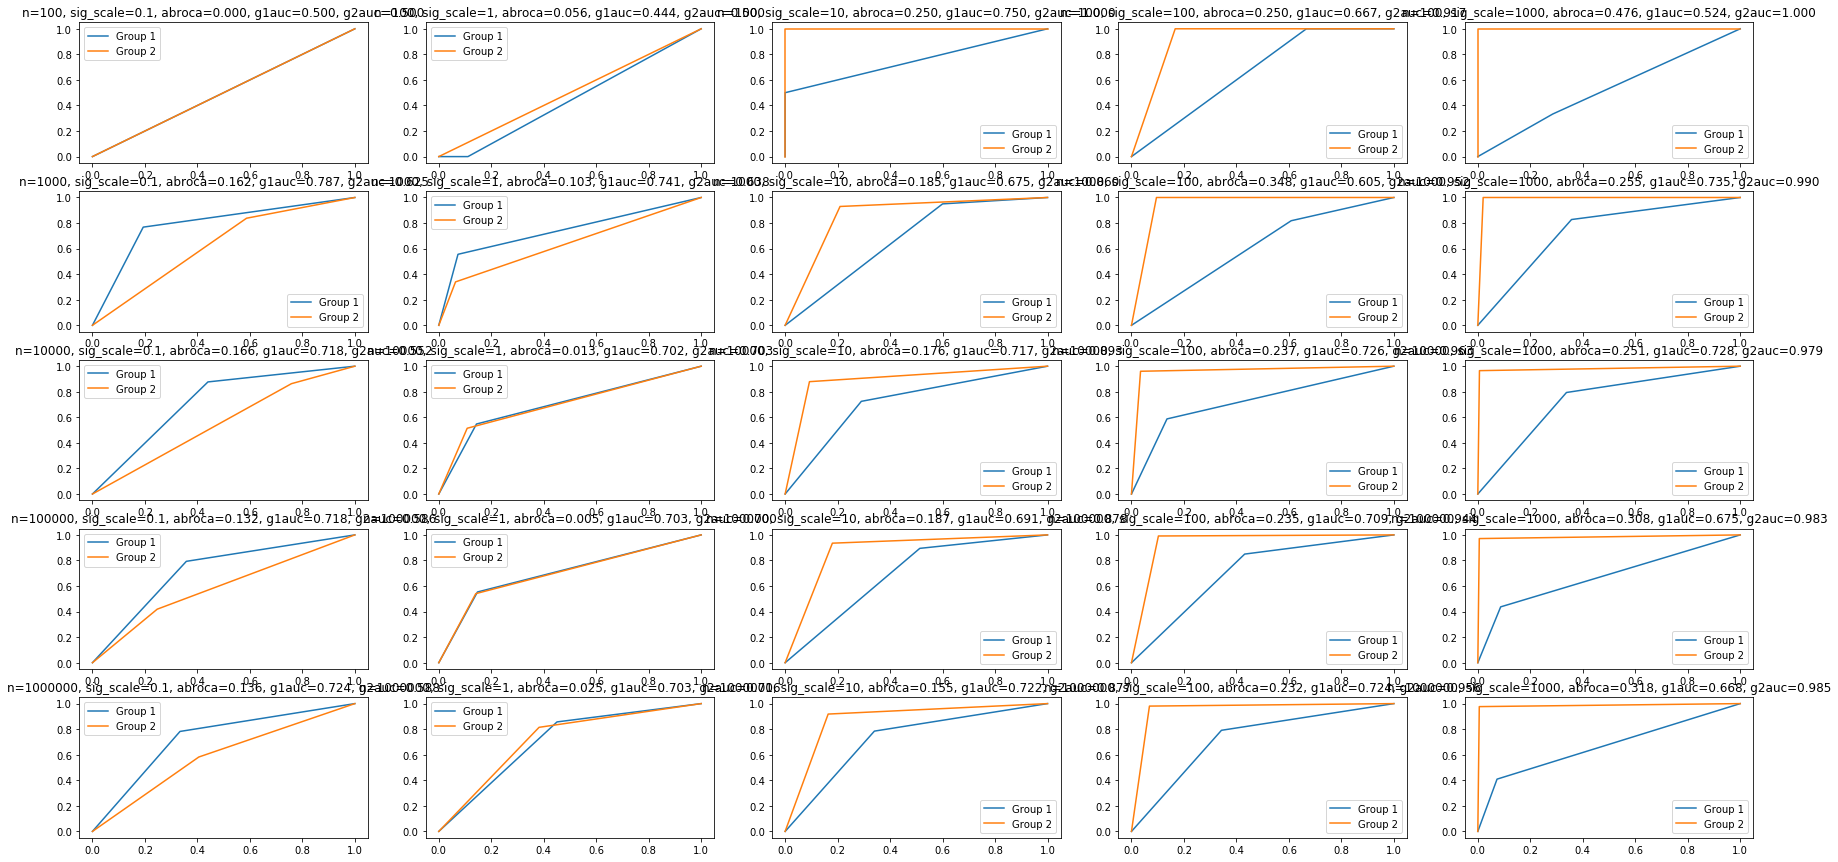

In [71]:
np.random.seed(13)
ns = [10**i for i in range(2,7)]
sig_scale_factors = [10**i for i in range(-1,4)]
fig, axs = plt.subplots(len(ns), len(sig_scale_factors), figsize=(30,15))

avg_auc = []
for row, a_n in enumerate(ns):
    for col, a_s in enumerate(sig_scale_factors):
        
        n = [a_n//2, a_n//2]
        X, y = simulate(sigma_scale_factor=a_s, subgroup_n=n, sigma_1=[1,1], sigma_2=[1,1], eta_sd=1)

        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

        X_train = np.append(X_train_0, X_train_1, axis=0)
        y_train = np.append(y_train_0, y_train_1, axis=0)


        #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
        #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
        regressor = LogisticRegressionCV(cv=5, random_state=0)
        
        regressor.fit(X_train, y_train)

        y_pred_0 = regressor.predict(X_test_0)
        y_pred_1 = regressor.predict(X_test_1)
        
        fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
        fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)
        
        g1auc = auc(fpr_0, tpr_0)
        g2auc = auc(fpr_1, tpr_1)
        avg_auc += [g1auc, g2auc]
        abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
        
        axs[row, col].plot(fpr_0, tpr_0, label='Group 1')
        axs[row, col].plot(fpr_1, tpr_1, label='Group 2')
        axs[row, col].legend()
        axs[row, col].set_title(f"n={sum(n)}, sig_scale={a_s}, abroca={abroca:.3f}, g1auc={g1auc:.3f}, g2auc={g2auc:.3f}")        

print(f"average auc score: {np.mean([_ for _ in avg_auc if not math.isnan(_)])}")

### Observation Noise VS ABROCA

In [54]:
np.random.seed(13)
eta_sds = [10**i for i in np.arange(-3,3,0.5)]

abrocas = []
for e in eta_sds:  
    n = [100000, 100000]
    X, y = simulate(subgroup_n=n, eta_sd=e)

    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)
    

    #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
    regressor = LogisticRegressionCV(cv=5, random_state=0)
    print()
    regressor.fit(X_train, y_train)

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g1auc = auc(fpr_0, tpr_0)
    g2auc = auc(fpr_1, tpr_1)

    abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
    abrocas.append(abroca)

plt.plot(eta_sds,abrocas,marker='.')
plt.xlabel('eta standard devation')
plt.ylabel('abroca score')
plt.title('Abroca VS Observation Noise')
plt.show()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

### Group Imbalance VS ABROCA

In [ ]:
np.random.seed(13)
eta_sds = [10**i for i in range(-3,3)]

abrocas = []
for e in eta_sds:  
    n = [100000, 100000]
    X, y = simulate(subgroup_n=n, eta_sd=e)

    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)
    

    #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
    regressor = LogisticRegressionCV(cv=5, random_state=0)
    print()
    regressor.fit(X_train, y_train)

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g1auc = auc(fpr_0, tpr_0)
    g2auc = auc(fpr_1, tpr_1)

    abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
    abrocas.append(abroca)

plt.plot(eta_sds,abrocas,marker='.')
plt.xlabel('eta standard devation')
plt.ylabel('abroca score')
plt.title('Abroca VS Observation Noise')
plt.show()

### Difference in groupwise feature means VS ABROCA

In [ ]:
np.random.seed(13)
eta_sds = [10**i for i in range(-3,3)]

abrocas = []
for e in eta_sds:  
    n = [100000, 100000]
    X, y = simulate(subgroup_n=n, eta_sd=e)

    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)
    

    #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
    regressor = LogisticRegressionCV(cv=5, random_state=0)
    print()
    regressor.fit(X_train, y_train)

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g1auc = auc(fpr_0, tpr_0)
    g2auc = auc(fpr_1, tpr_1)

    abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
    abrocas.append(abroca)

plt.plot(eta_sds,abrocas,marker='.')
plt.xlabel('eta standard devation')
plt.ylabel('abroca score')
plt.title('Abroca VS Observation Noise')
plt.show()